In [13]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import nlp_prepare
import nlp_acquire
import env
from env import user, password, host

1. Spam data


In [14]:
def get_spam_data():
    url = env.get_db_url(user, password, host,'spam_db')
    sql = "SELECT * FROM spam"

    df = pd.read_sql(sql, url, index_col="id")
    return df

In [15]:
df = get_spam_data()

In [16]:
df

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."


In [17]:
def clean_data(text):
    ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [18]:
ham_corpus = clean_data(' '.join(df[df.label == 'ham'].text))
spam_corpus = clean_data(' '.join(df[df.label == 'spam'].text))
all_corpus = clean_data(' '.join(df.text))

In [19]:
ham_freq = pd.Series(ham_corpus).value_counts()
spam_freq = pd.Series(spam_corpus).value_counts()
all_freq = pd.Series(all_corpus).value_counts()

In [20]:
all_freq

call             600
im               462
get              397
ur               384
go               304
                ... 
cage               1
surrounded         1
cuck               1
weeddeficient      1
bitching           1
Length: 8900, dtype: int64

In [21]:
spam_freq.nlargest(20)

call       359
free       216
txt        150
ur         144
text       137
mobile     135
4          119
claim      115
stop       113
reply      102
prize       94
get         83
tone        73
service     72
new         69
send        67
nokia       65
urgent      63
week        62
cash        62
dtype: int64

In [22]:
ham_freq.nlargest(20)

im      449
get     314
go      273
ok      272
dont    257
come    242
know    241
call    241
ur      240
ill     236
like    232
got     231
good    223
day     214
time    213
love    193
want    183
need    171
one     170
4       168
dtype: int64

- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?


In [23]:
def make_bigrams(s, n = 2):
    return (pd.Series(nltk.ngrams(s, n))).value_counts()

make_bigrams(ham_corpus)

(call, later)     52
(ill, call)       48
(let, know)       42
(sorry, ill)      39
(dont, know)      32
                  ..
(cant, ever)       1
(master, cant)     1
(dont, master)     1
(biro, dont)       1
(true, name)       1
Length: 30869, dtype: int64

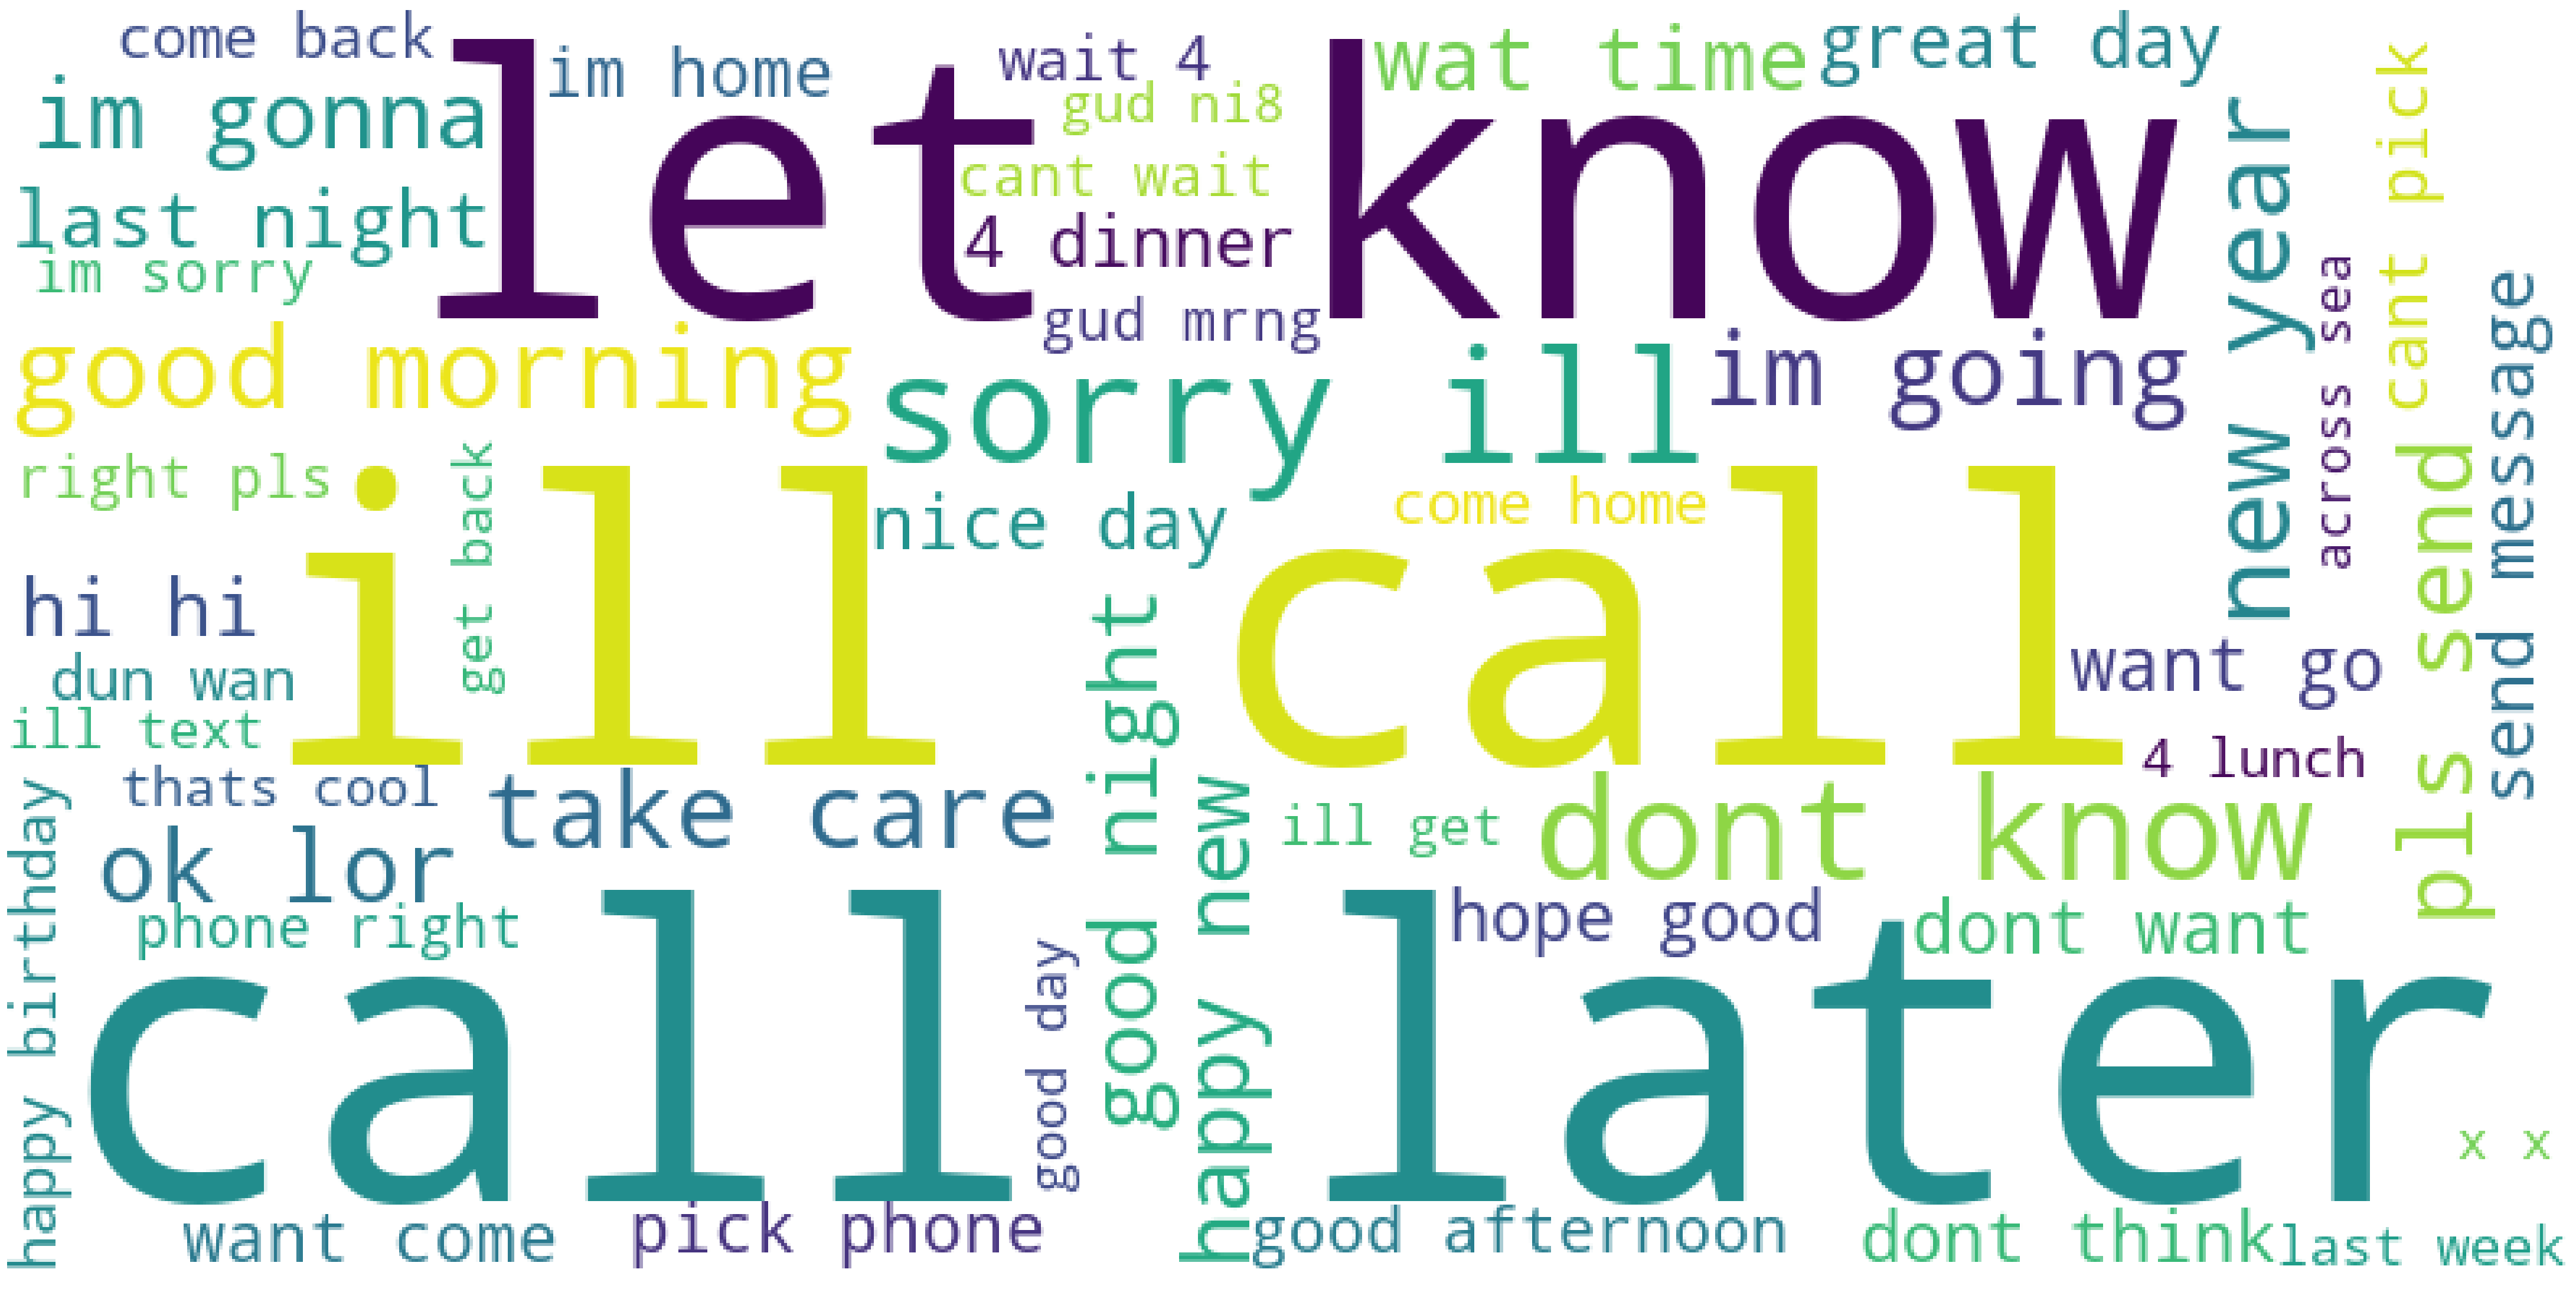

In [24]:
def make_bigram_cloud(s, top = 20, width = 800, height = 400):
    """ s = series of bigram count """
    data = {' '.join(k) : v for k, v in s.nlargest(top).to_dict().items()}
    img = WordCloud(background_color = 'white', width = width, height = height).generate_from_frequencies(data)
    plt.figure(figsize=(width/10, height/10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

make_bigram_cloud(make_bigrams(ham_corpus), top = 50)

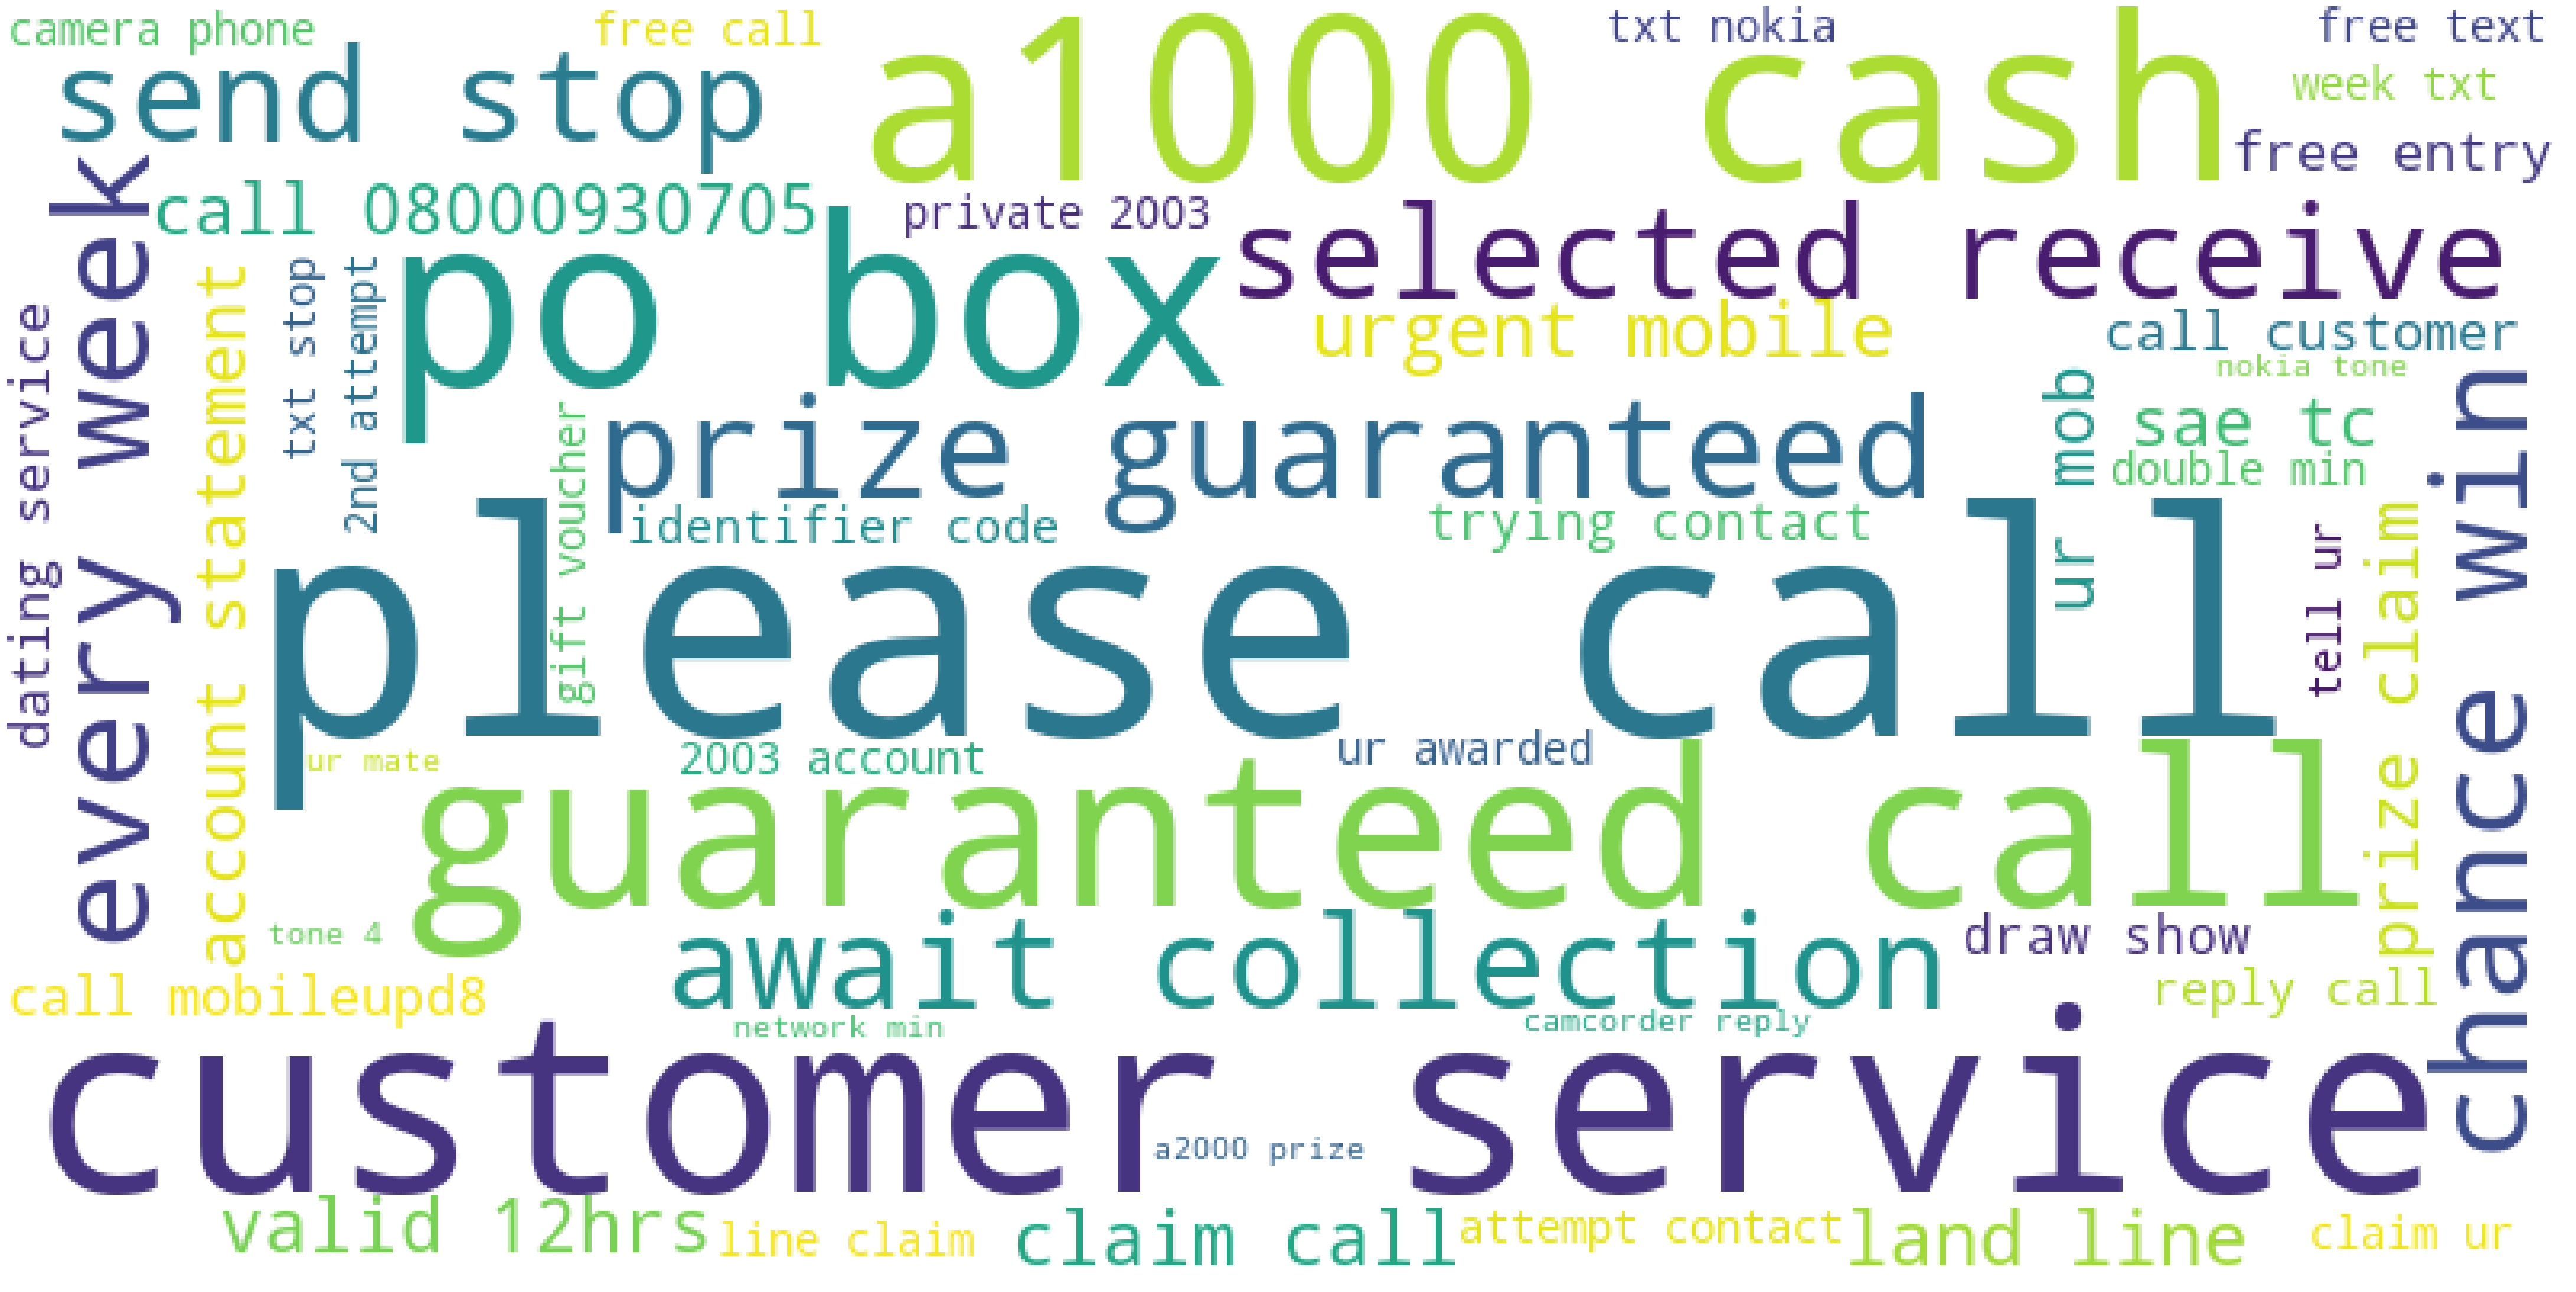

In [25]:
make_bigram_cloud(make_bigrams(spam_corpus), top = 50)

Is there any overlap in the bigrams for the spam data and the ham data?

In [26]:
all_corpus_bigrams = pd.DataFrame({'all_corpus':make_bigrams(all_corpus)})
ham_corpus_bigrams = pd.DataFrame({'ham_corpus':make_bigrams(ham_corpus)})
spam_corpus_bigrams = pd.DataFrame({'spam_corpus':make_bigrams(spam_corpus)})

In [27]:
all_and_ham = all_corpus_bigrams.join(ham_corpus_bigrams, how = 'left')
bigram_counts = all_and_ham.join(spam_corpus_bigrams, how='left').fillna(0)

In [28]:
#183 of the bigrams overlap
bigram_counts[(bigram_counts.ham_corpus != 0) & (bigram_counts.spam_corpus != 0)]

,all_corpus,ham_corpus,spam_corpus
"(please, call)",53,9.0,44.0
"(dont, know)",38,32.0,6.0
"(new, year)",32,30.0,2.0
"(customer, service)",29,2.0,27.0
"(po, box)",25,1.0,24.0
...,...,...,...
"(next, month)",2,1.0,1.0
"(could, meet)",2,1.0,1.0
"(today, ur)",2,1.0,1.0
"(tomorrow, ur)",1,1.0,1.0


Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [29]:
def make_compare_df(n_gram = 3):
    ham_corpus = clean_data(' '.join(df[df.label == 'ham'].text))
    spam_corpus = clean_data(' '.join(df[df.label == 'spam'].text))
    all_corpus = clean_data(' '.join(df.text))
    all_corpus_ngrams = pd.DataFrame({'all_corpus':make_bigrams(all_corpus, n = n_gram)})
    ham_corpus_ngrams = pd.DataFrame({'ham_corpus':make_bigrams(ham_corpus, n = n_gram)})
    spam_corpus_ngrams = pd.DataFrame({'spam_corpus':make_bigrams(spam_corpus, n = n_gram)})
    all_and_ham = all_corpus_ngrams.join(ham_corpus_ngrams, how = 'left')
    ngram_counts = all_and_ham.join(spam_corpus_ngrams, how='left').fillna(0)
    return ngram_counts

def find_overlap(df):
    return df[(df.ham_corpus != 0) & (df.spam_corpus != 0)]

def make_barchart(df):
    sns.countplot(x=df.index)

In [30]:

make_compare_df(n_gram=3)

,all_corpus,ham_corpus,spam_corpus
"(ill, call, later)",42,42.0,0.0
"(sorry, ill, call)",38,38.0,0.0
"(prize, guaranteed, call)",21,0.0,21.0
"(happy, new, year)",19,19.0,0.0
"(call, customer, service)",15,0.0,15.0
...,...,...,...
"(bed, throw, laundry)",1,1.0,0.0
"(throw, laundry, top)",1,1.0,0.0
"(laundry, top, cant)",1,1.0,0.0
"(top, cant, friend)",1,1.0,0.0


In [31]:
find_overlap(make_compare_df(n_gram=3))

,all_corpus,ham_corpus,spam_corpus
"(please, call, back)",5,1.0,4.0
"(sorry, missed, call)",3,2.0,1.0
"(number, im, glad)",2,1.0,1.0
"(new, year, eve)",2,1.0,1.0
"(called, left, message)",2,1.0,1.0


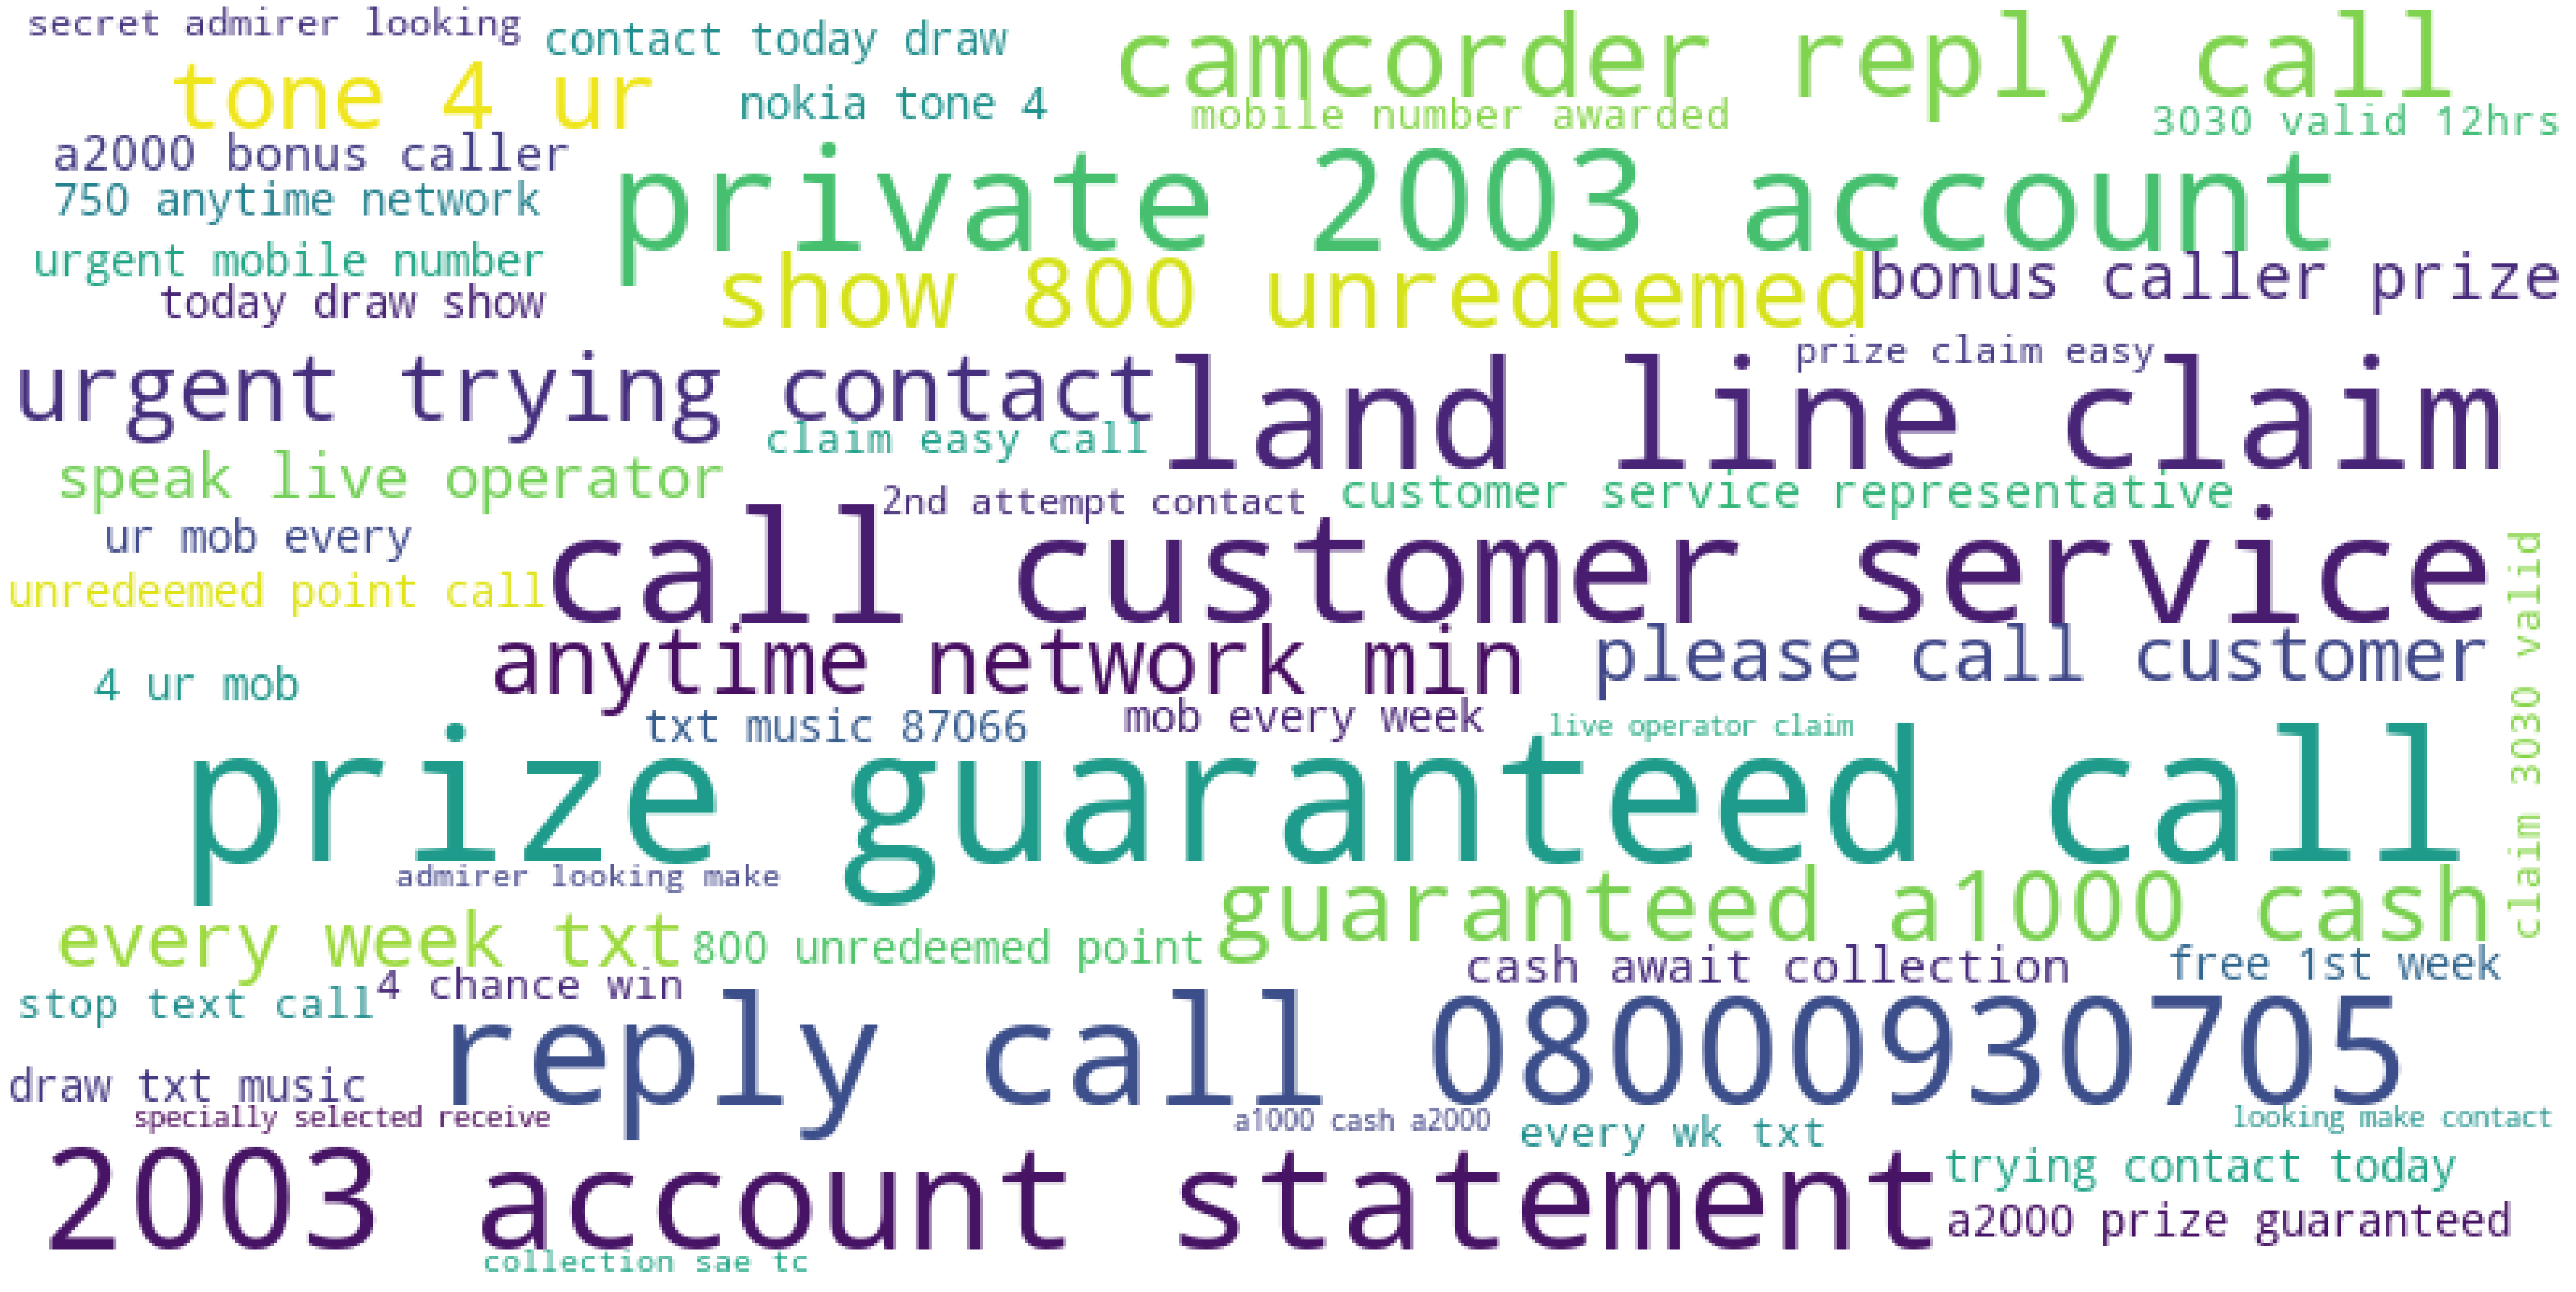

In [32]:

make_bigram_cloud(make_bigrams(spam_corpus, n = 3), top = 50)

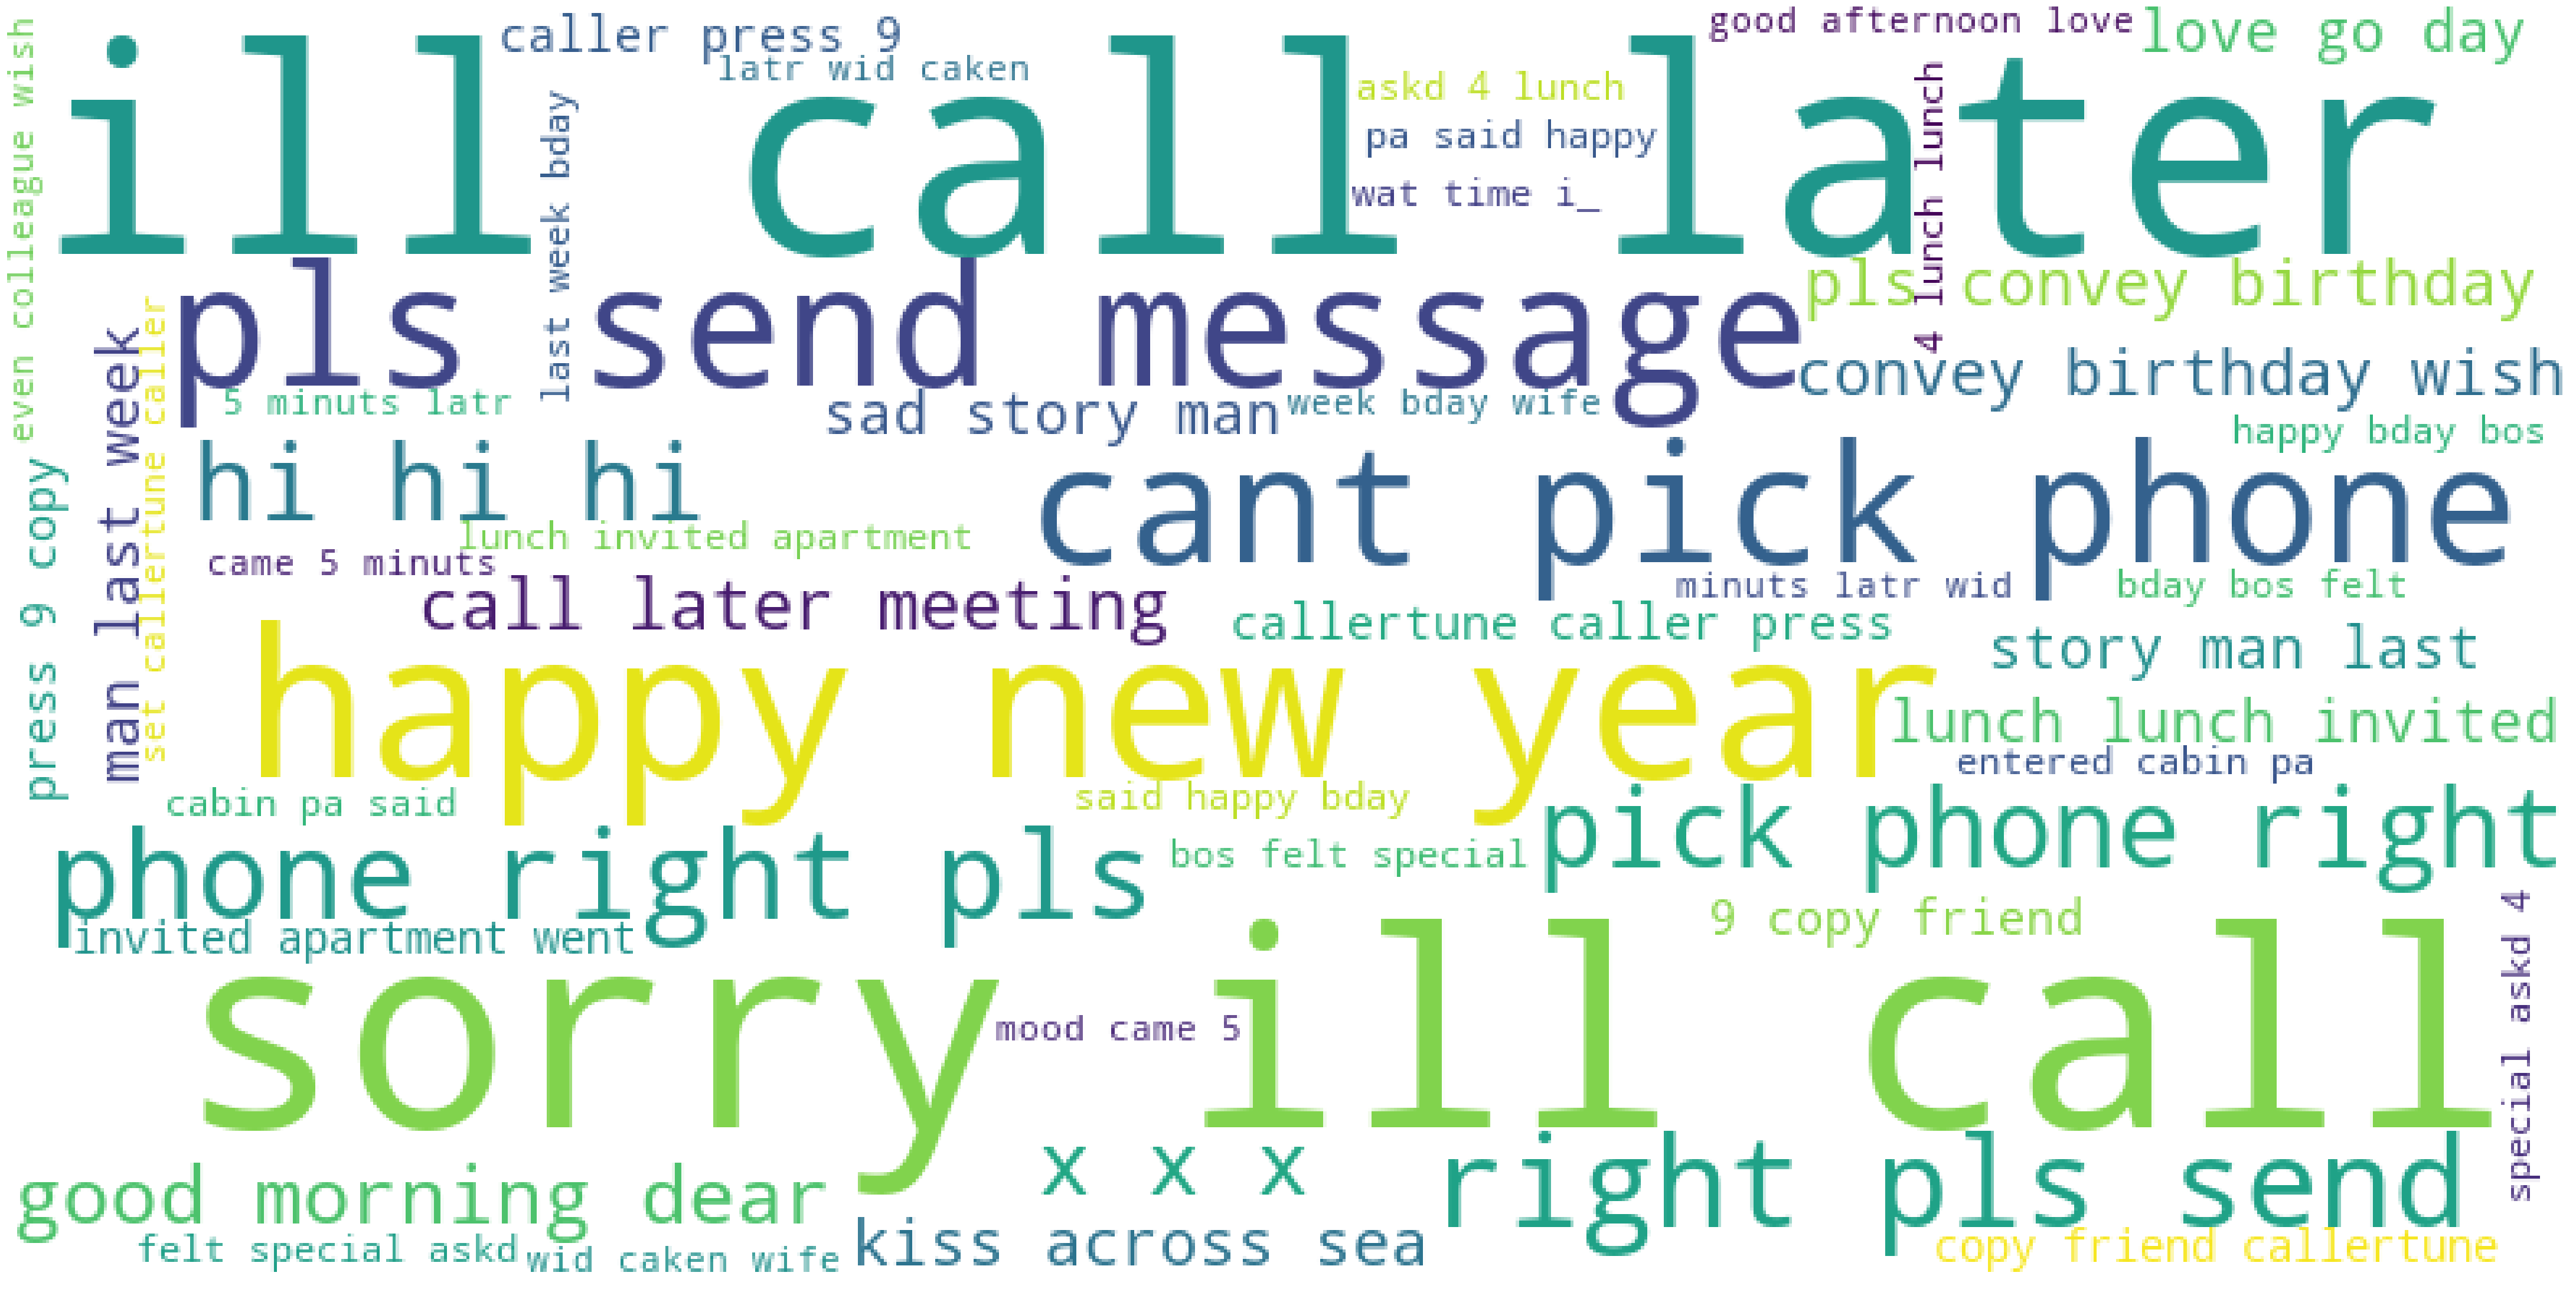

In [33]:
make_bigram_cloud(make_bigrams(ham_corpus, n = 3), top = 50)

<AxesSubplot:>

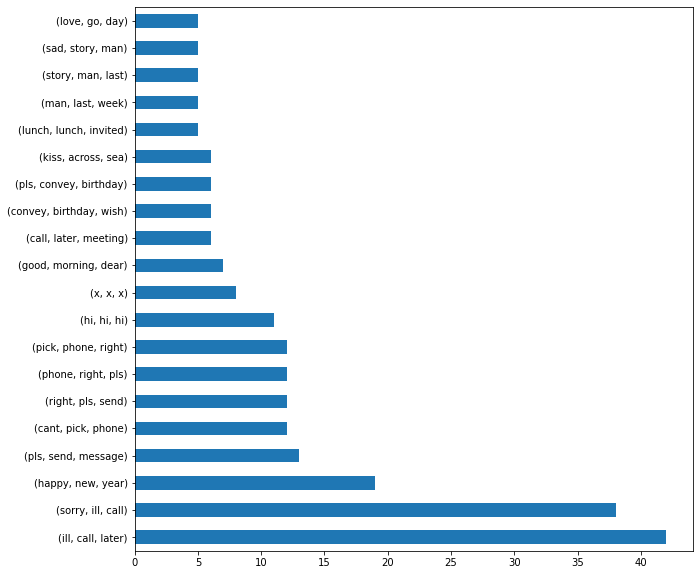

In [34]:
plt.figure(figsize=(10,10))
make_bigrams(ham_corpus, n = 3).nlargest(20).plot.barh()

<AxesSubplot:>

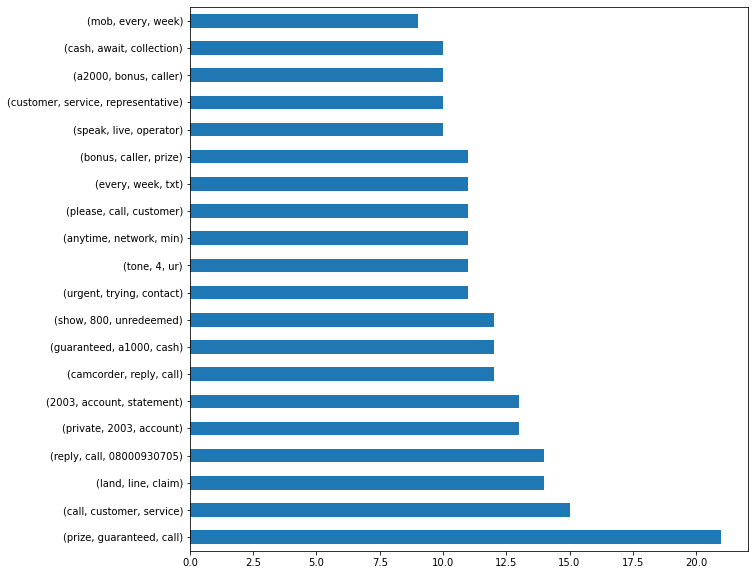

In [35]:
plt.figure(figsize=(10,10))
make_bigrams(spam_corpus, n = 3).nlargest(20).plot.barh()

1. Explore the blog articles using the techniques discussed in the exploration lesson.

In [36]:
blog_df = nlp_prepare.make_dataframe(nlp_acquire.read_url_or_file_codeup())

Found File


In [37]:
blog_df.sample(2)

,title,content,clean,stemmed,lemmatized
4,codeup tv commercial,codeup has officially made its tv debut our co...,"[officially, made, tv, debut, community, stude...","[offici, made, tv, debut, commun, student, sta...","[officially, made, tv, debut, community, stude..."
3,codeups new dallas campus,codeups dallas campus has a new location for m...,"[codeups, dallas, campus, new, location, two, ...","[codeup, dalla, campu, new, locat, two, year, ...","[codeups, dallas, campus, new, location, two, ..."


In [38]:
blog_corpus = ' '.join([' '.join(x) for x in (blog_df['clean'].tolist())]).split()
blog_corpus_lemma = ' '.join([' '.join(x) for x in (blog_df['lemmatized'].tolist())]).split()

In [39]:
blog_corpus_freq = pd.Series(blog_corpus).value_counts()

In [40]:
blog_lemma_freq = pd.Series(blog_corpus_lemma).value_counts()

<AxesSubplot:>

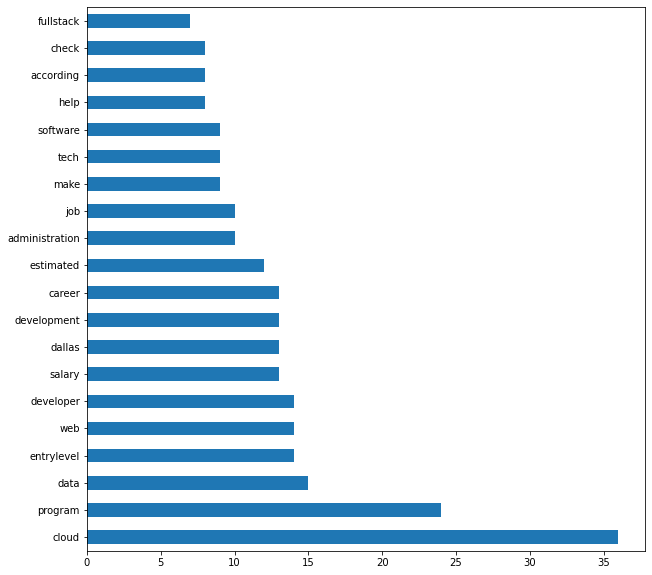

In [41]:
#blog is pushing the cloud academy
plt.figure(figsize=(10,10))
blog_lemma_freq.nlargest(20).plot.barh()

<AxesSubplot:>

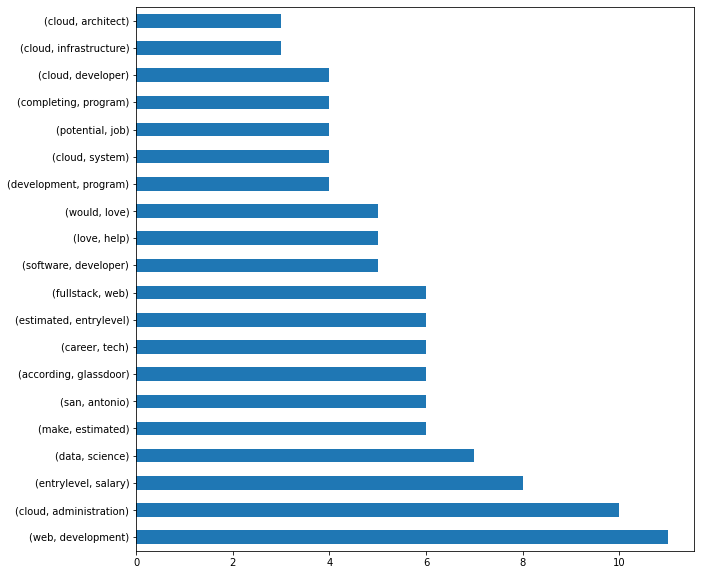

In [42]:
#blog is pushing the cloud admin and data science
plt.figure(figsize=(10,10))
make_bigrams(blog_corpus_lemma).nlargest(20).plot.barh()

- Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.


In [43]:
news_df = nlp_prepare.make_dataframe(nlp_acquire.read_url_or_file_inshort())
news_df

Found File


,title,content,clean,stemmed,lemmatized
0,ed arrests former nse ceo ravi narain in money...,the enforcement directorate has arrested ravi ...,"[enforcement, directorate, arrested, ravi, nar...","[enforc, director, arrest, ravi, narain, forme...","[enforcement, directorate, arrested, ravi, nar..."
1,musks lawyer seeks to delay twitter trial to i...,tesla ceo elon musks lawyer urged that the tri...,"[tesla, ceo, elon, musks, lawyer, urged, trial...","[tesla, ceo, elon, musk, lawyer, urg, trial, 4...","[tesla, ceo, elon, musk, lawyer, urged, trial,..."
2,no sense to buy twitter if were heading into w...,amid their lawsuit twitters lawyer revealed a ...,"[amid, lawsuit, twitters, lawyer, revealed, te...","[amid, lawsuit, twitter, lawyer, reveal, text,...","[amid, lawsuit, twitter, lawyer, revealed, tex..."
3,bytedance fires hundreds of employees from vid...,tiktoks parent company bytedance has reportedl...,"[tiktoks, parent, company, bytedance, reported...","[tiktok, parent, compani, byted, reportedli, f...","[tiktoks, parent, company, bytedance, reported..."
4,are you kidding me easemytrip cofounder shares...,easemytrip cofounder prashant pitti took to tw...,"[easemytrip, cofounder, prashant, pitti, took,...","[easemytrip, cofound, prashant, pitti, took, t...","[easemytrip, cofounder, prashant, pitti, took,..."
...,...,...,...,...,...
93,didnt know much about vicky was won over when ...,actress katrina kaif during her appearance on ...,"[actress, katrina, kaif, appearance, koffee, k...","[actress, katrina, kaif, appear, koffe, karan,...","[actress, katrina, kaif, appearance, koffee, k..."
94,superhero films worldwide have high budgets we...,filmmaker rakesh roshan speaking about krrish ...,"[filmmaker, rakesh, roshan, speaking, krrish, ...","[filmmak, rakesh, roshan, speak, krrish, 4, sa...","[filmmaker, rakesh, roshan, speaking, krrish, ..."
95,parents rejected films after iqbal for me to h...,actress shweta basu prasad who featured as a c...,"[actress, shweta, basu, prasad, featured, chil...","[actress, shweta, basu, prasad, featur, child,...","[actress, shweta, basu, prasad, featured, chil..."
96,was planning to do an album with bamba bakya a...,composersinger ar rahman remembered late playb...,"[composersinger, ar, rahman, remembered, late,...","[composersing, ar, rahman, rememb, late, playb...","[composersinger, ar, rahman, remembered, late,..."


In [44]:
news_corpus = ' '.join([' '.join(x) for x in (news_df['clean'].tolist())]).split()
news_corpus_lemma = ' '.join([' '.join(x) for x in (news_df['lemmatized'].tolist())]).split()

In [45]:
news_corpus_freq = pd.Series(news_corpus).value_counts()
news_lemma_freq = pd.Series(news_corpus_lemma).value_counts()

<AxesSubplot:>

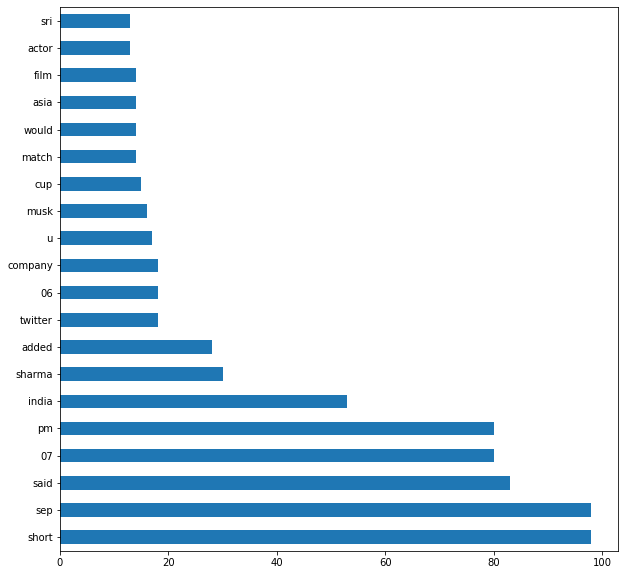

In [46]:
#blog is pushing the cloud academy
plt.figure(figsize=(10,10))
news_lemma_freq.nlargest(20).plot.barh()

<AxesSubplot:>

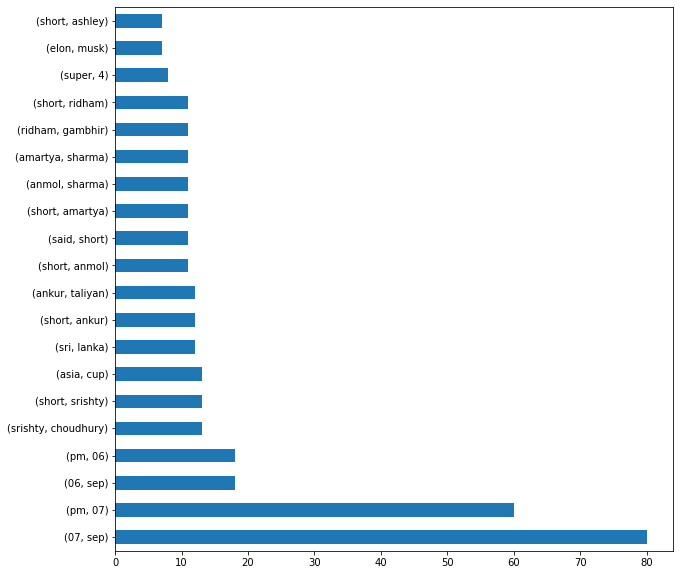

In [47]:
#blog is pushing the cloud admin and data science
plt.figure(figsize=(10,10))
make_bigrams(news_corpus_lemma).nlargest(20).plot.barh()

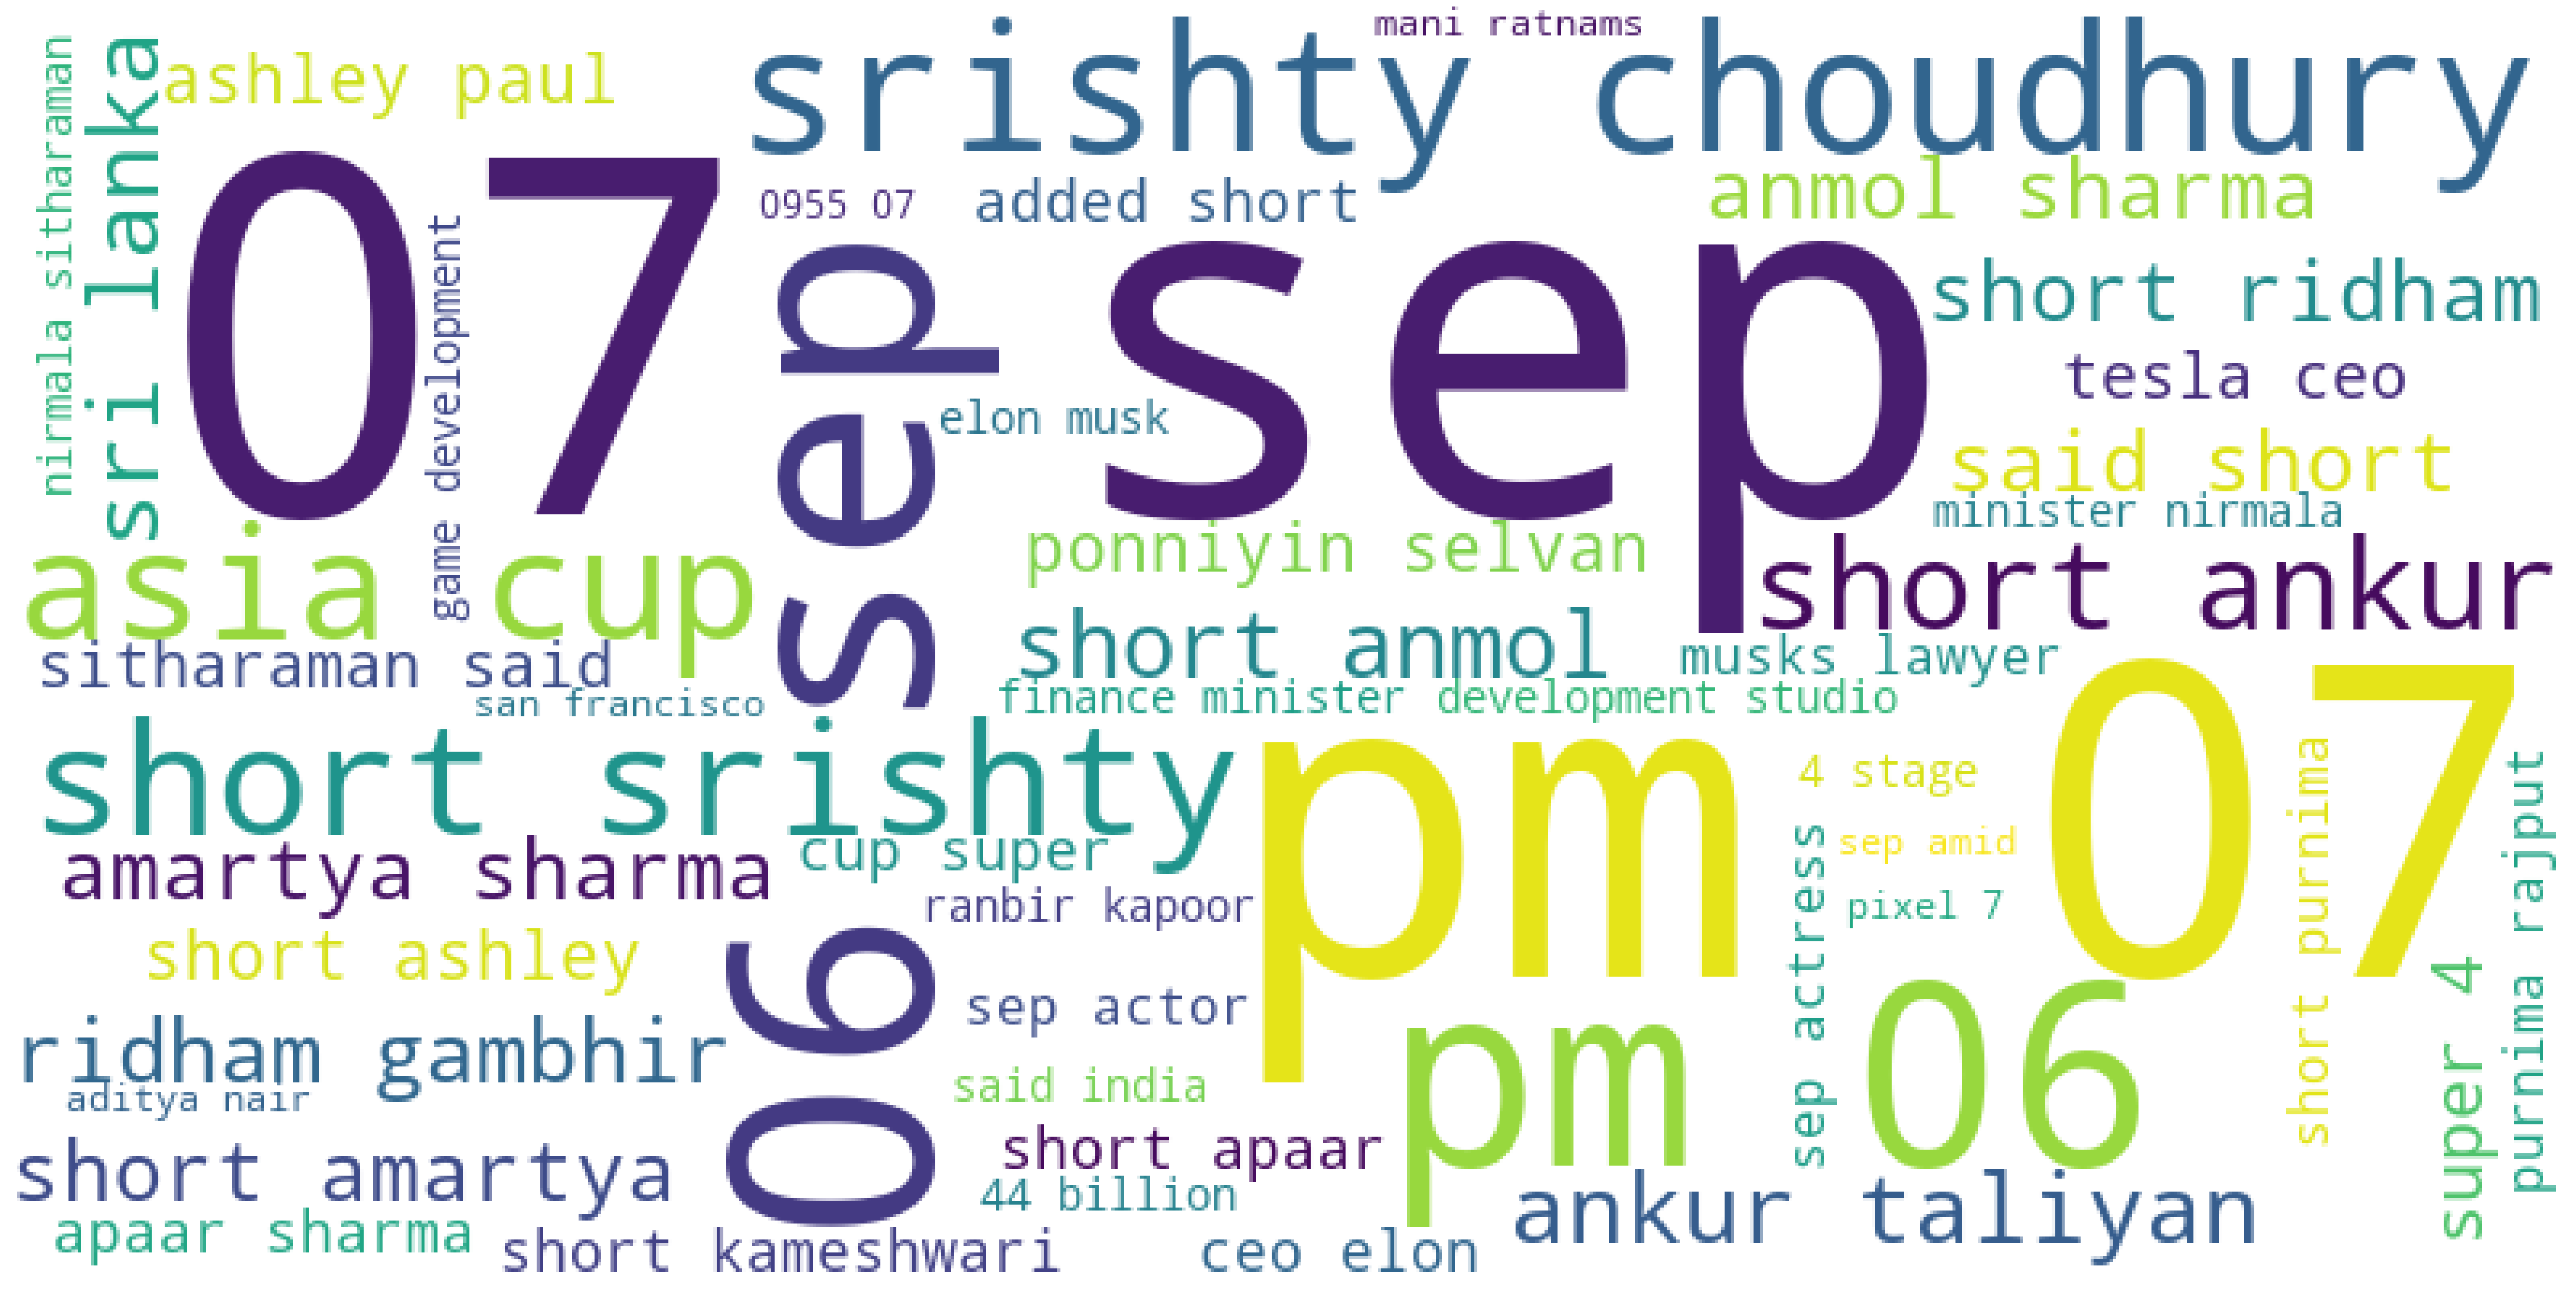

In [48]:
make_bigram_cloud(make_bigrams(news_corpus, n = 2), top = 50)